# AutoML percentile-bias correction on M4 (XGBoost)

This notebook compares baseline AutoML forecasts vs. `percentile_correction=True` using M4 Weekly data.

In [8]:
import numpy as np
import pandas as pd
from scipy import stats
from utilsforecast.losses import rmse

from datasetsforecast.m4 import M4, M4Info
from datasetsforecast.m3 import M3, M3Info
from mlforecast.auto import xgboost_space
import optuna

from utilsforecast.losses import rmse, mse, bias, mae

def eval_metrics(valid_df, preds_df, model_col: str):
    df = valid_df.merge(preds_df, on=["unique_id", "ds"], how="inner")
    return {
        "rows": len(df),
        "rmse": float(rmse(df, models=[model_col], id_col="unique_id", target_col="y")[model_col].mean()),
        "mse": float(mse(df, models=[model_col], id_col="unique_id", target_col="y")[model_col].mean()),
        "bias": float(bias(df, models=[model_col], id_col="unique_id", target_col="y")[model_col].mean()),
        "mae": float(mae(df, models=[model_col], id_col="unique_id", target_col="y")[model_col].mean()),
    }

def rmse_loss(df, train_df):  # train_df is unused here
    # df has columns: ["unique_id", "ds", "cutoff", "y", "model"]
    return rmse(df, models=["model"], id_col="unique_id", target_col="y")["model"].mean()

In [9]:
import pandas as pd

def rolling_holdout_splits(df, h, n_test_sets, time_col="ds"):
    # ensure datetime
    ds = pd.to_datetime(df[time_col])
    all_ds = sorted(ds.unique())
    max_ds = all_ds[-1]

    step = pd.Timedelta(days=1) 

    for k in range(n_test_sets):
        test_end = max_ds - k * h * step
        test_start = test_end - (h - 1) * step

        train = df[df[time_col] < test_start]
        test = df[(df[time_col] >= test_start) & (df[time_col] <= test_end)]

        yield k, train.reset_index(drop=True), test.reset_index(drop=True)


In [10]:
def tweedie_space(trial):
    params = xgboost_space(trial)
    params["objective"] = "reg:tweedie"
    params["tweedie_variance_power"] = 1.5
    params["eval_metric"] = "tweedie-nloglik@1.5"
    return params


In [11]:
from sklearn.preprocessing import FunctionTransformer
from mlforecast.target_transforms import LocalStandardScaler, GlobalSklearnTransformer

from mlforecast.lag_transforms import (RollingMean, ExponentiallyWeightedMean, ExpandingMax, ExpandingMin,
                                       RollingStd)

LAGS = [
    [1],
    [1, 2, 3],
    [1, 2, 3, 7],
    [1, 7, 14],
    [1, 7, 14, 28],
]

LAG_TRANSFORMS = [
    {1: [ExponentiallyWeightedMean(0.9),
         ExpandingMax(),
         ExpandingMin(),
         RollingStd(window_size=3, min_samples=1),
         RollingStd(window_size=8, min_samples=3),
         RollingMean(window_size=3, min_samples=1),
         RollingMean(window_size=8, min_samples=3)
         ]
     },
   # {
   #     1: [ExponentiallyWeightedMean(0.9)],
   #     7: [RollingMean(window_size=3, min_samples=1)],
   # },
]

DATE_FEATURES = ["year", "month", "week", "weekday"]  # standard calendar features

def my_init_config(trial):
    lags_idx = trial.suggest_int("lags_idx", 0, len(LAGS) - 1)
    ltfm_idx = trial.suggest_int("lag_tfms_idx", 0, len(LAG_TRANSFORMS) - 1)
    return {
        "target_transforms": None,   # no differencing
        "lags": LAGS[lags_idx],
        "lag_transforms": LAG_TRANSFORMS[ltfm_idx],
        "date_features": ["weekday", "week", "month"]

    }


In [12]:
from datasetsforecast.m5 import M5

Y_df, X_df, S_df = M5.load(directory="data")

In [13]:
all_ids = Y_df.unique_id.unique().tolist()

rng = np.random.default_rng(42)
sample_ids = rng.choice(all_ids, size=200, replace=False).tolist()

df = Y_df[Y_df.unique_id.isin(sample_ids)]

df.shape

(310683, 3)

In [42]:
def my_fit_config(trial):
    return {
        "dropna": False,
    }
    
n_test_sets = 10
h = 7
n_windows = 25
num_samples = 10
step_size = 3

rmse_base_test = []
mse_base_test = []
mae_base_test = []
bias_base_test = []

rmse_corr_test = []
mse_corr_test = []
mae_corr_test = []
bias_corr_test = []

cv_rmse_normal_cv = []
cv_bias_normal_cv = []

cv_rmse_corr_cv = []
cv_bias_corr_cv = []

rmse_base_only_corrected_test = []
mse_base_only_corrected_test = []
mae_base_only_corrected_test = []
bias_base_only_corrected_test = []

rmse_corr_only_corrected_test = []
mse_corr_only_corrected_test = []
mae_corr_only_corrected_test = []
bias_corr_only_corrected_test = []

share_correction = []
p_val_cv = []

for i, train_i, test_i in rolling_holdout_splits(df, h, n_test_sets):
    from mlforecast.auto import AutoMLForecast, AutoXGBoost, PredictionIntervals
    
    #auto_base = AutoMLForecast(
    #models={"xgb": AutoXGBoost(config=tweedie_space)},
    #freq="D",
    #init_config=my_init_config,
    #fit_config=my_fit_config,
    #reuse_cv_splits=True
    #)

    auto_corr = AutoMLForecast(
        models={"xgb": AutoXGBoost(config=tweedie_space)},
        freq="D",
        init_config=my_init_config,
        fit_config=my_fit_config,
        reuse_cv_splits=True
    )
    
    print(i, train_i.ds.min(), train_i.ds.max(), " | ", 
          test_i.ds.min(), test_i.ds.max())

    length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()

    good_ids = length_ids[length_ids.ds > 100].unique_id.unique()

    train_i = train_i[train_i.unique_id.isin(good_ids)].copy()
    test_i = test_i[test_i.unique_id.isin(good_ids)].copy()
    
    # Train base model:
    #auto_base.fit(
    #df=train_i,
    #n_windows=n_windows,
    #h=h,
    #num_samples=num_samples,
    #step_size=5,
    #loss=rmse_loss,
    #study_kwargs={"sampler": optuna.samplers.TPESampler()}
    # prediction_intervals=PredictionIntervals(n_windows=n_windows, h=h),
    #)

    #preds_base = auto_base.predict(h=test_i.ds.nunique())
    #metrics_base = eval_rmse_bias(test_i, preds_base, "xgb")
    
    # Train corrected model:
    auto_corr.percentile_correction_levels_ = list(range(1, 51))
    auto_corr.fit(
    df=train_i,
    n_windows=n_windows,
    h=h,
    num_samples=num_samples,
    step_size=step_size,
    prediction_intervals=PredictionIntervals(n_windows=6, h=h),
    percentile_correction=True,
    compute_corrected_cv_metrics=True,
    loss=rmse_loss,
    study_kwargs={"sampler": optuna.samplers.TPESampler()}
    )

    preds_corr = auto_corr.predict(h=test_i.ds.nunique())
    
    name = "xgb"
    corr = auto_corr.percentile_correction_[name]
    corr_ids = list(corr["id_to_col"].keys())
    raw_preds = auto_corr.models_[name].predict(
        h=test_i.ds.nunique(),
        level=corr["levels"],  # make sure percentile cols exist
    )
    
    metrics_corr = eval_metrics(test_i, preds_corr, "xgb")
    metrics_base = eval_metrics(test_i, raw_preds, "xgb")
    
    metrics_corr_only_corrected = eval_metrics(test_i[test_i.unique_id.isin(corr_ids)], 
                                                 preds_corr[preds_corr.unique_id.isin(corr_ids)], "xgb")
    metrics_base_only_corrected = eval_metrics(test_i[test_i.unique_id.isin(corr_ids)], 
                                                 raw_preds[raw_preds.unique_id.isin(corr_ids)], "xgb")
    
    rmse_base = metrics_base['rmse']
    mse_base = metrics_base['mse']
    mae_base = metrics_base['mae']
    bias_base = metrics_base['bias']
    
    rmse_corr = metrics_corr['rmse']
    mse_corr = metrics_corr['mse']
    mae_corr = metrics_corr['mae']
    bias_corr = metrics_corr['bias']
    
    rmse_base_only_corrected = metrics_base_only_corrected['rmse']
    mse_base_only_corrected = metrics_base_only_corrected['mse']
    mae_base_only_corrected = metrics_base_only_corrected['mae']
    bias_base_only_corrected = metrics_base_only_corrected['bias']
    
    rmse_corr = metrics_corr['rmse']
    mse_corr = metrics_corr['mse']
    mae_corr = metrics_corr['mae']
    bias_corr = metrics_corr['bias']
    
    rmse_corr_only_corrected = metrics_corr_only_corrected ['rmse']
    mse_corr_only_corrected = metrics_corr_only_corrected ['mse']
    mae_corr_only_corrected = metrics_corr_only_corrected ['mae']
    bias_corr_only_corrected = metrics_corr_only_corrected ['bias']
    
    cv_rmse_normal = auto_corr.cv_metrics_["xgb"]['rmse']
    cv_bias_normal = auto_corr.cv_metrics_["xgb"]['bias']
    
    cv_rmse_corr = auto_corr.cv_metrics_corrected_["xgb"]['rmse']
    cv_bias_corr = auto_corr.cv_metrics_corrected_["xgb"]['bias']
    
    #############
    # save outputs
    rmse_base_test.append(rmse_base)
    mse_base_test.append(mse_base)
    mae_base_test.append(mae_base)
    bias_base_test.append(bias_base)
    
    rmse_corr_test.append(rmse_corr)
    mse_corr_test.append(mse_corr)
    mae_corr_test.append(mae_corr)
    bias_corr_test.append(bias_corr)
    
    rmse_base_only_corrected_test.append(rmse_base_only_corrected)
    mse_base_only_corrected_test.append(mse_base_only_corrected)
    mae_base_only_corrected_test.append(mae_base_only_corrected)
    bias_base_only_corrected_test.append(bias_base_only_corrected)
    
    rmse_corr_only_corrected_test.append(rmse_corr_only_corrected)
    mse_corr_only_corrected_test.append(mse_corr_only_corrected)
    mae_corr_only_corrected_test.append(mae_corr_only_corrected)
    bias_corr_only_corrected_test.append(bias_corr_only_corrected)
    
    cv_rmse_normal_cv.append(cv_rmse_normal)
    cv_bias_normal_cv.append(cv_bias_normal)
    
    cv_rmse_corr_cv.append(cv_rmse_corr)
    cv_bias_corr_cv.append(cv_bias_corr)
    ###############
    # Get base and corrected forecast from correction model:
    

    # raw predictions WITH the needed percentile columns
    #raw_preds = auto_corr.models_[name].predict(
    #    h=test_i.ds.nunique(),
    #    level=corr["levels"],  # make sure percentile cols exist
    #)

    # corrected predictions (auto_corr.predict applies correction)
    preds_optimal = auto_corr.predict(h=test_i.ds.nunique())
    ###############
    preds_all = raw_preds.merge(preds_optimal, on=['ds', 'unique_id'])
    
    corr_ids_str = set(map(str, corr_ids))
    preds_all = preds_all[preds_all.unique_id.astype(str).isin(corr_ids_str)]
    
    preds_all = preds_all.merge(test_i, on=['ds', 'unique_id'])

    preds_all['res_base'] = abs(preds_all.xgb_x - preds_all.y)
    preds_all['res_best'] = abs(preds_all.xgb_y - preds_all.y)

    preds_all['flag'] = np.where(preds_all.res_best < preds_all.res_base, 1, 0)
    share_correction.append(preds_all['flag'].mean())
    #############
    # Run t-test:
    t_stat, p_val = stats.ttest_ind(preds_all.xgb_x, 
                                preds_all.xgb_y, 
                                equal_var=True)  
    p_val_cv.append(p_val)

0 2011-01-29 00:00:00 2016-06-12 00:00:00  |  2016-06-13 00:00:00 2016-06-19 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 22:31:28,450] A new study created in memory with name: no-name-d02fb742-aca4-4649-b53d-f6b7c7902f55
[I 2026-02-22 22:31:31,654] Trial 0 finished with value: 1.35565185546875 and parameters: {'n_estimators': 173, 'max_depth': 7, 'learning_rate': 0.10431091211836593, 'subsample': 0.28833089430021797, 'colsample_bytree': 0.31655937082991487, 'reg_lambda': 6.235259422632278e-07, 'reg_alpha': 2.6940690708253344e-07, 'min_child_weight': 4, 'lags_idx': 0, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.35565185546875.
[I 2026-02-22 22:31:34,731] Trial 1 finished with value: 1.397670030593872 and

1 2011-01-29 00:00:00 2016-06-05 00:00:00  |  2016-06-06 00:00:00 2016-06-12 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 22:35:02,810] A new study created in memory with name: no-name-9d86f728-171f-4f4f-aad4-d5b2b572ad46
[I 2026-02-22 22:35:09,374] Trial 0 finished with value: 1.3662896156311035 and parameters: {'n_estimators': 676, 'max_depth': 7, 'learning_rate': 0.06148154757149556, 'subsample': 0.1409195216853691, 'colsample_bytree': 0.2913445426356215, 'reg_lambda': 7.240779928182779e-05, 'reg_alpha': 0.009793294837566406, 'min_child_weight': 9, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.3662896156311035.
[I 2026-02-22 22:35:12,225] Trial 1 finished with value: 1.2724311351776123 an

2 2011-01-29 00:00:00 2016-05-29 00:00:00  |  2016-05-30 00:00:00 2016-06-05 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 22:49:50,362] A new study created in memory with name: no-name-f851f896-ce62-432d-8eae-0d1650fd8757
[I 2026-02-22 22:50:03,282] Trial 0 finished with value: 1.3230334520339966 and parameters: {'n_estimators': 818, 'max_depth': 9, 'learning_rate': 0.0022498694911408977, 'subsample': 0.8890654508771008, 'colsample_bytree': 0.8970295275879732, 'reg_lambda': 0.00018839499406135413, 'reg_alpha': 0.05921811825509747, 'min_child_weight': 4, 'lags_idx': 2, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.3230334520339966.
[I 2026-02-22 22:50:08,964] Trial 1 finished with value: 1.5578120946884155 

3 2011-01-29 00:00:00 2016-05-22 00:00:00  |  2016-05-23 00:00:00 2016-05-29 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 22:51:55,135] A new study created in memory with name: no-name-3bb97e99-bc65-4385-b265-27208c105fd4
[I 2026-02-22 22:51:57,473] Trial 0 finished with value: 1.2809486389160156 and parameters: {'n_estimators': 324, 'max_depth': 2, 'learning_rate': 0.11357251918731816, 'subsample': 0.4818150990245618, 'colsample_bytree': 0.9022582502311137, 'reg_lambda': 0.0009604336462745506, 'reg_alpha': 5.714271322661114e-06, 'min_child_weight': 2, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2809486389160156.
[I 2026-02-22 22:52:01,968] Trial 1 finished with value: 1.295068383216858 an

4 2011-01-29 00:00:00 2016-05-15 00:00:00  |  2016-05-16 00:00:00 2016-05-22 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 22:57:50,250] A new study created in memory with name: no-name-735184be-3d98-451c-ad8c-2ccd8efa625e
[I 2026-02-22 22:58:02,838] Trial 0 finished with value: 1.2608855962753296 and parameters: {'n_estimators': 946, 'max_depth': 9, 'learning_rate': 0.006774520641852396, 'subsample': 0.8686915538730371, 'colsample_bytree': 0.3293674145950102, 'reg_lambda': 0.05281402129350222, 'reg_alpha': 1.468240767514116e-06, 'min_child_weight': 6, 'lags_idx': 3, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2608855962753296.
[I 2026-02-22 22:58:09,993] Trial 1 finished with value: 1.4735937118530273 an

5 2011-01-29 00:00:00 2016-05-08 00:00:00  |  2016-05-09 00:00:00 2016-05-15 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 23:10:29,856] A new study created in memory with name: no-name-c3763c55-3876-4c04-a464-1a38383b3d1b
[I 2026-02-22 23:10:34,267] Trial 0 finished with value: 1.2663682699203491 and parameters: {'n_estimators': 766, 'max_depth': 2, 'learning_rate': 0.11946530329431922, 'subsample': 0.36819684763196364, 'colsample_bytree': 0.4240079157728106, 'reg_lambda': 7.620579567373535e-08, 'reg_alpha': 5.348459693744781e-05, 'min_child_weight': 5, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2663682699203491.
[I 2026-02-22 23:10:39,192] Trial 1 finished with value: 1.419654130935669 a

6 2011-01-29 00:00:00 2016-05-01 00:00:00  |  2016-05-02 00:00:00 2016-05-08 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 23:15:38,700] A new study created in memory with name: no-name-61e452e1-be8f-4eb6-a5ea-ed8be3920c67
[I 2026-02-22 23:15:47,789] Trial 0 finished with value: 1.297434687614441 and parameters: {'n_estimators': 519, 'max_depth': 10, 'learning_rate': 0.020326416523268803, 'subsample': 0.6168800477843529, 'colsample_bytree': 0.30928225032051376, 'reg_lambda': 5.991404370924901e-06, 'reg_alpha': 5.878947116132142e-06, 'min_child_weight': 9, 'lags_idx': 2, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.297434687614441.
[I 2026-02-22 23:16:00,782] Trial 1 finished with value: 1.435828447341919 a

7 2011-01-29 00:00:00 2016-04-24 00:00:00  |  2016-04-25 00:00:00 2016-05-01 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 23:19:10,264] A new study created in memory with name: no-name-ed04c3ad-a3e8-4a37-ab2b-c9d3736e2984
[I 2026-02-22 23:19:15,190] Trial 0 finished with value: 1.2583940029144287 and parameters: {'n_estimators': 373, 'max_depth': 7, 'learning_rate': 0.016958530075289763, 'subsample': 0.6222076379108694, 'colsample_bytree': 0.6696420921042788, 'reg_lambda': 1.9157807294196254e-06, 'reg_alpha': 0.02918299092672759, 'min_child_weight': 9, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2583940029144287.
[I 2026-02-22 23:19:20,958] Trial 1 finished with value: 1.320314645767212 an

8 2011-01-29 00:00:00 2016-04-17 00:00:00  |  2016-04-18 00:00:00 2016-04-24 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 23:24:28,218] A new study created in memory with name: no-name-93e3c79d-21f6-4f7b-b956-b224bc5f6cfa
[I 2026-02-22 23:24:38,072] Trial 0 finished with value: 1.2723389863967896 and parameters: {'n_estimators': 922, 'max_depth': 7, 'learning_rate': 0.004147908925473908, 'subsample': 0.4644783379817475, 'colsample_bytree': 0.22345718955337665, 'reg_lambda': 8.482927050050256e-07, 'reg_alpha': 3.331384379192555e-07, 'min_child_weight': 7, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.2723389863967896.
[I 2026-02-22 23:24:39,550] Trial 1 finished with value: 2.038738965988159 

9 2011-01-29 00:00:00 2016-04-10 00:00:00  |  2016-04-11 00:00:00 2016-04-17 00:00:00


/var/folders/nk/kvcs64mn4nbfqfw1ff_czjn80000gn/T/ipykernel_3737/3976383591.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()
[I 2026-02-22 23:34:00,706] A new study created in memory with name: no-name-48735d90-d8fe-45ce-bb5e-5d876c9263c6
[I 2026-02-22 23:34:02,082] Trial 0 finished with value: 1.9476398229599 and parameters: {'n_estimators': 128, 'max_depth': 1, 'learning_rate': 0.004520830031612261, 'subsample': 0.429065828231432, 'colsample_bytree': 0.10052950665515091, 'reg_lambda': 0.08796008852430391, 'reg_alpha': 0.07945298151989194, 'min_child_weight': 2, 'lags_idx': 1, 'lag_tfms_idx': 0}. Best is trial 0 with value: 1.9476398229599.
[I 2026-02-22 23:34:04,180] Trial 1 finished with value: 1.886702060699463 and paramet

In [43]:
metrics_corr_only_corrected

{'rows': 77,
 'rmse': 0.47343331575393677,
 'mse': 1.596929669380188,
 'bias': -0.030217617750167847,
 'mae': 0.4059619605541229}

In [44]:
metrics_base_only_corrected

{'rows': 77,
 'rmse': 0.628040075302124,
 'mse': 1.6780043840408325,
 'bias': 0.44891583919525146,
 'mae': 0.5328177809715271}

In [45]:
import numpy as np
count = np.sum(np.array(bias_corr_only_corrected_test) 
               < np.array(bias_base_only_corrected_test))
count / len(bias_base_only_corrected_test)


np.float64(1.0)

In [46]:
print(np.mean(rmse_base_only_corrected_test),
      np.mean(rmse_corr_only_corrected_test),
      
      
np.mean(np.abs(bias_base_only_corrected_test)),
np.mean(np.abs(bias_corr_only_corrected_test))
)

0.7749026104807853 0.6752233851701022 0.1810866787098348 0.16255125559400768


In [47]:
share_correction

[np.float64(1.0),
 np.float64(0.8333333333333334),
 np.float64(0.9047619047619048),
 np.float64(0.8571428571428571),
 np.float64(0.8857142857142857),
 np.float64(0.8285714285714286),
 np.float64(0.8979591836734694),
 np.float64(0.7922077922077922),
 np.float64(0.9047619047619048),
 np.float64(0.922077922077922)]

In [48]:
import numpy as np
print(
    np.mean(share_correction),
    np.std(share_correction),
    len(share_correction)
)


0.8826530612244898 0.05543847927900567 10


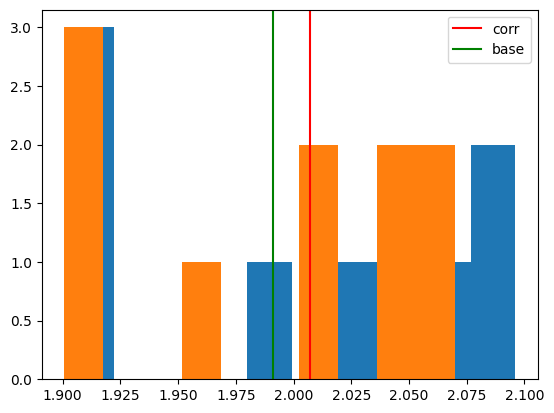

In [49]:
import matplotlib.pyplot as plt

plt.hist(cv_rmse_corr_cv)
plt.axvline(np.mean(cv_rmse_corr_cv), color='red', label='corr')
plt.hist(cv_rmse_normal_cv)
plt.axvline(np.mean(cv_rmse_normal_cv),  color='green', label='base')
plt.legend()
plt.show()

In [64]:
np.mean(rmse_corr_test) / np.mean(rmse_base_test) - 1

np.float64(-0.0031908205888206975)

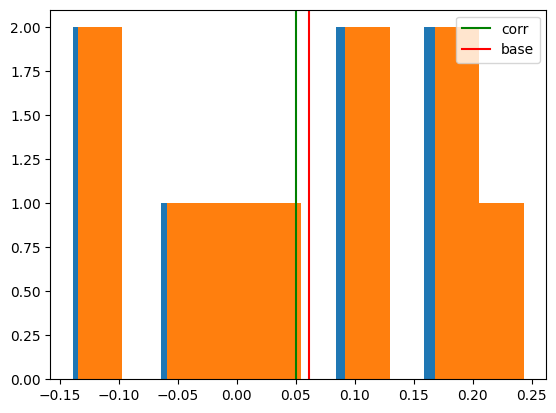

In [50]:
plt.hist(bias_corr_test)
plt.axvline(np.mean(bias_corr_test), label='corr', color='green')
plt.hist(bias_base_test)
plt.axvline(np.mean(bias_base_test), label='base', color='red')
plt.legend()
plt.show()

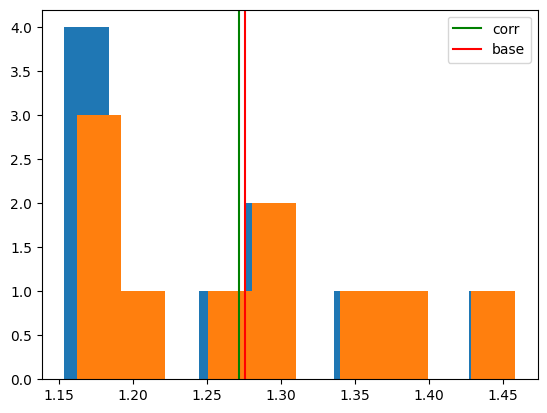

In [51]:
plt.hist(rmse_corr_test)
plt.axvline(np.mean(rmse_corr_test), label='corr', color='green')
plt.hist(rmse_base_test)
plt.axvline(np.mean(rmse_base_test), label='base', color='red')
plt.legend()
plt.show()

In [53]:
count = np.sum(np.array(mae_corr_test) 
               < np.array(mae_base_test))
count / len(bias_base_only_corrected_test)

np.float64(1.0)

In [56]:
print(np.mean(mae_corr_test),
np.mean((mae_base_test)))

1.0554659128189088 1.0610901832580566


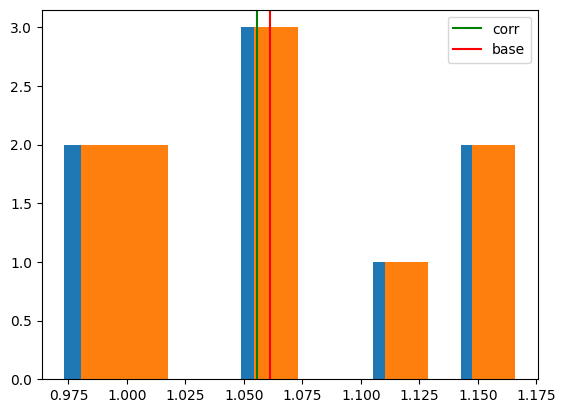

In [54]:
plt.hist(mae_corr_test)
plt.axvline(np.mean(mae_corr_test), label='corr', color='green')
plt.hist(mae_base_test)
plt.axvline(np.mean(mae_base_test), label='base', color='red')
plt.legend()
plt.show()

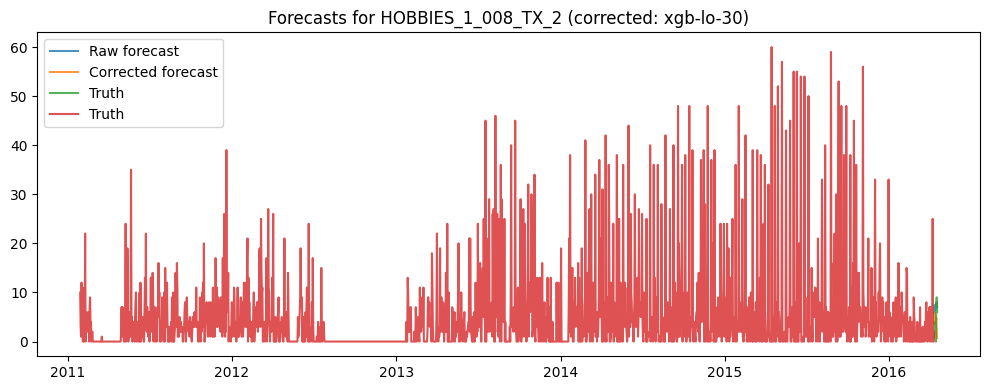

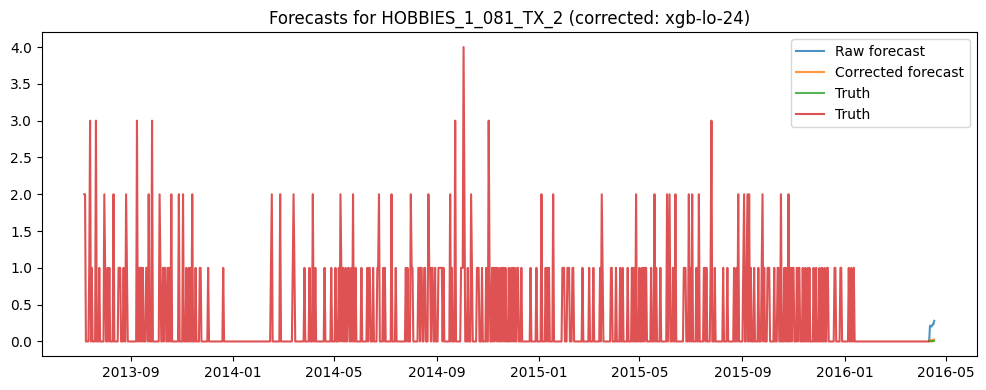

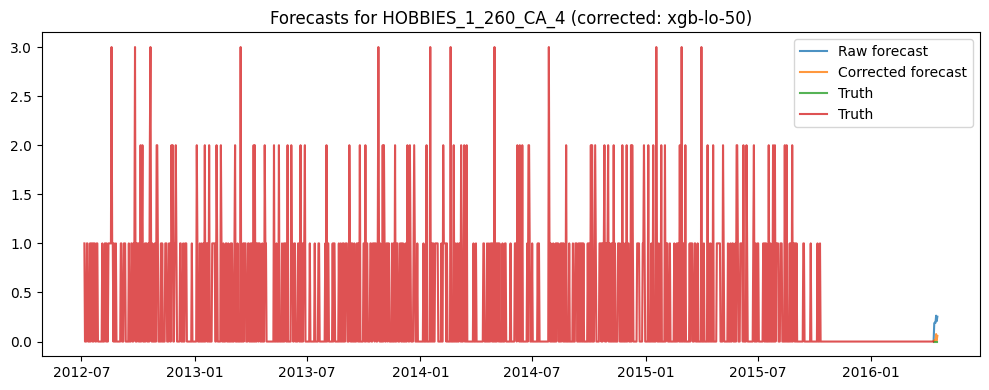

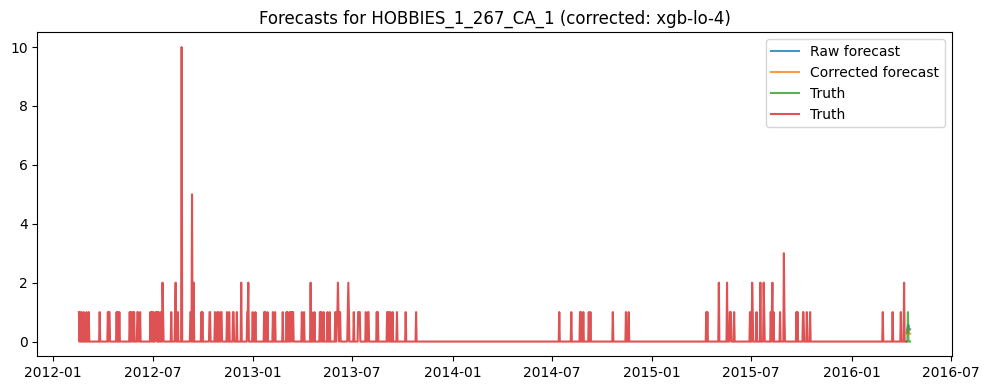

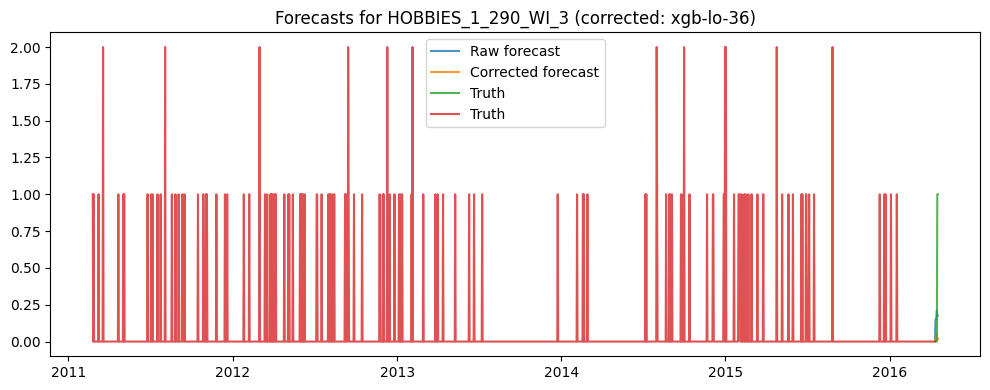

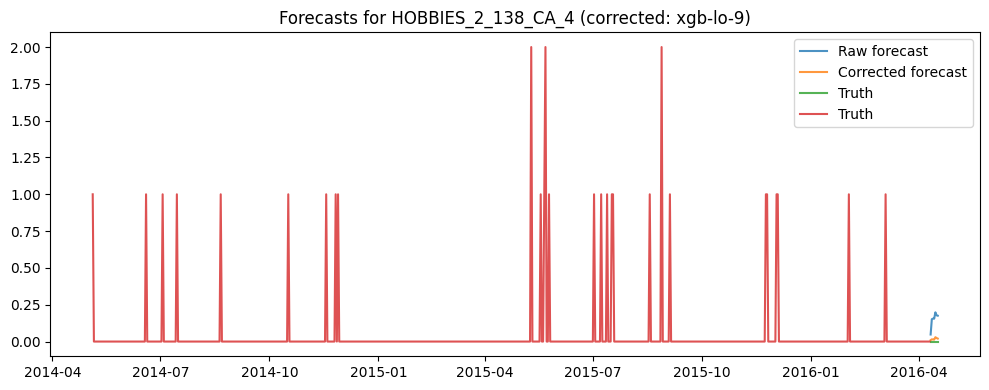

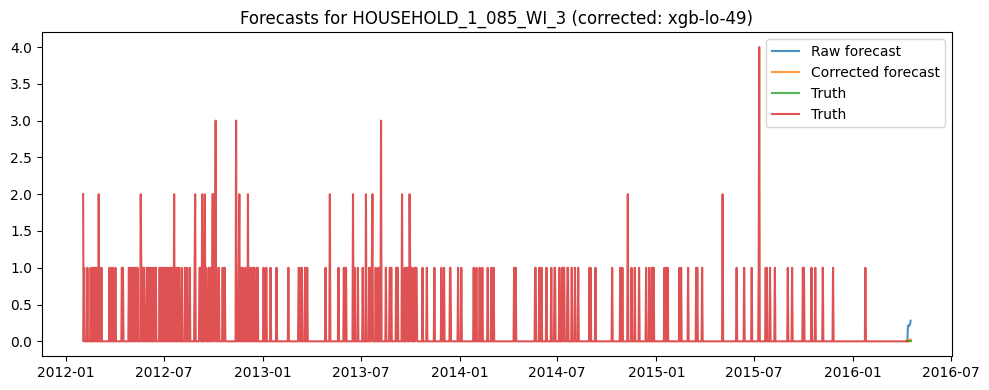

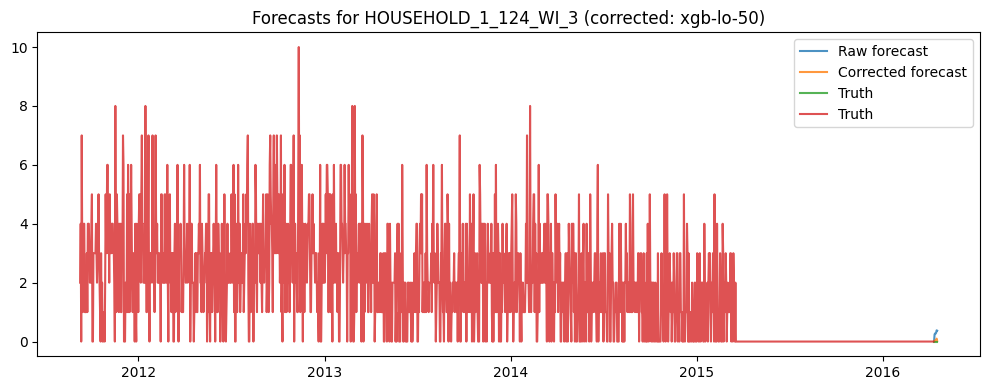

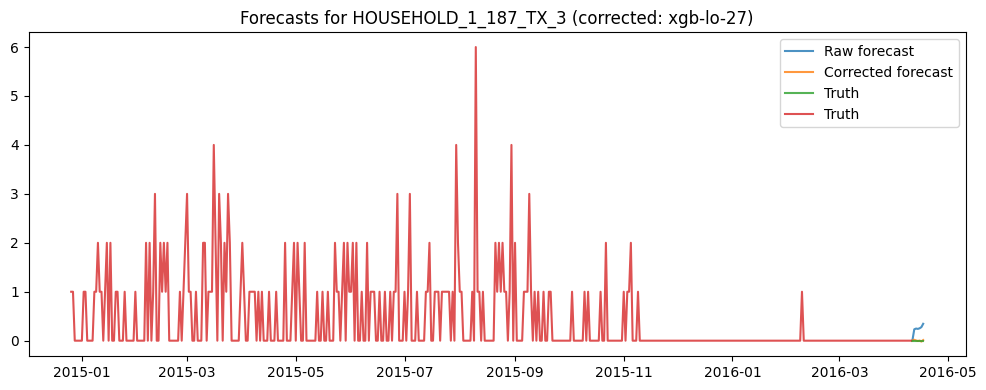

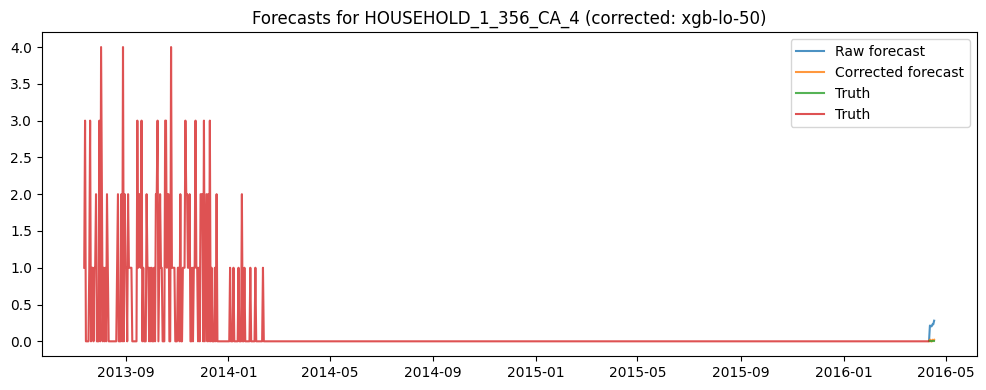

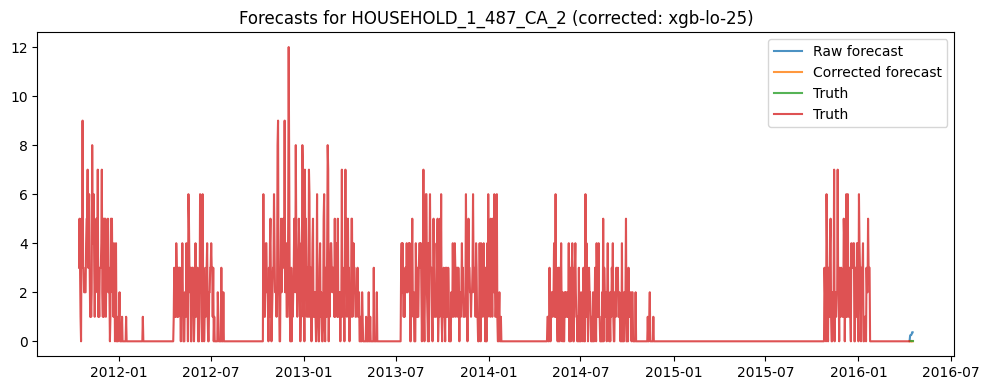

In [55]:
import matplotlib.pyplot as plt

name = "xgb"
corr = auto_corr.percentile_correction_[name]
corr_ids = list(corr["id_to_col"].keys())

# raw predictions WITH the needed percentile columns
raw_preds = auto_corr.models_[name].predict(
    h=h,
    level=corr["levels"],  # make sure percentile cols exist
)

# corrected predictions (auto_corr.predict applies correction)
corr_preds = auto_corr.predict(h=h)

for uid in corr_ids[0:15]:
    raw_uid = raw_preds[raw_preds["unique_id"] == uid]
    corr_uid = corr_preds[corr_preds["unique_id"] == uid]
    test_uid = test_i[test_i["unique_id"] == uid]
    train_uid = train_i[train_i["unique_id"] == uid]
    

    plt.figure(figsize=(10, 4))
    #plt.plot(valid_uid["ds"], valid_uid["y"], label="Actuals (valid.y)", color="black", alpha=0.8)
    plt.plot(raw_uid["ds"], raw_uid[name], label="Raw forecast", alpha=0.8)
    plt.plot(corr_uid["ds"], corr_uid[name], label="Corrected forecast", alpha=0.8)
    plt.plot(test_uid["ds"], test_uid['y'], label="Truth", alpha=0.8)
    plt.plot(train_uid["ds"], train_uid['y'], label="Truth", alpha=0.8)
    plt.title(f"Forecasts for {uid} (corrected: {corr['id_to_col'][uid]})")
    plt.legend()
    plt.tight_layout()
    plt.show()
